## Homework 02-2: due 2022/03/14 13:10

### - Tutorial : https://machinelearningmastery.com/pytorch-tutorial-develop-deep-learning-models/

### - After you go through the tutorials, you should be able to work on this assignment.

### - Please answer the following questions and work directly on this jupyter notebook.

### - Make sure the code can be run and show the result and figures properly.

### - Please write down your observation with markdown in this notebook briefly.



#### You will train a regression model in this part. The data is **Concrete Compressive Strength Dataset**, you can find the details of each column at https://archive.ics.uci.edu/ml/datasets/concrete+compressive+strength

In [146]:
# Import necessory modules
%matplotlib inline
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler

In [187]:
# For reproduce the result
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

### 1. Define the model and dataset 

#### 1-1. Please follow the tutorial to create a class **ConcreteDataset**, for loading the data you need and also do the Min-Max scaling to the feature and label. In this part, please predict the **strength of concrete**. 

In [188]:
class ConcreteDataset(Dataset):
    def __init__(self, csv_path):
        df = pd.read_csv(csv_path)
        self.X = df.iloc[:, :-1].values
        self.y = df.iloc[:, -1].values
        self.X_scaler = MinMaxScaler()
        self.y_scaler = MinMaxScaler()
        self.X = self.X_scaler.fit_transform(self.X)
        self.y = self.y.reshape(len(self.y), 1)
        self.y = self.y_scaler.fit_transform(self.y)
        
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        feature = torch.tensor(self.X[idx], dtype=torch.float32)
        label = torch.tensor(self.y[idx], dtype=torch.float32)
        return feature, label
        

#### 2-2. By following the tutorial, try to create a class **MLP(Neural Network)** with three hidden layers as your network architecture. 

In [189]:
class MLP(nn.Module):
    def __init__(self, input_ch=30, first_layers=256, second_layers=64, third_layers=8, activation=nn.Sigmoid(), output_act=nn.Tanh()):
        super(MLP, self).__init__()
        self.model = nn.Sequential( nn.Linear(input_ch, first_layers), 
                                    activation, 
                                    nn.Linear(first_layers, second_layers), 
                                    activation, 
                                    nn.Linear(second_layers, third_layers), 
                                    activation, 
                                    nn.Linear(third_layers, 1) )
                                    
        
        self.output_act = output_act
    
    def forward(self, X):
        X = self.model(X)
        X = self.output_act(X)
        return X        

### 2. Train the model

#### 2.1 Please load the ***train.csv/ validation.csv*** in ./data, and turn them into dataloader with batch size 64 and determine whether shuffle or not.

In [204]:
train_ds = ConcreteDataset("./data/train_noise.csv")
val_ds = ConcreteDataset("./data/validation.csv")

In [205]:
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=False)

#### 2.2 Create two MLP model from the table below and print the model:
##### (Note. The output layer and activation function you should determine by the task and the dataset.) 
| | First Layer | Second Layer | Third Layer | Activation between each two layers | Output Activation |
|:---:|:---:|:---:|:---:|:---:|:---:|
|***Model1***| 256 | 64 | 8 | Tanh | Tanh |
|***Model1***| 64 | 16 | 8 | Sigmoid | Pure Linear |

In [192]:
models = {"Model1" : MLP(input_ch=8, first_layers=256, second_layers=64, third_layers=8, activation=nn.Tanh(), output_act = nn.Tanh()), 
            "Model2" : MLP(input_ch=8, first_layers=64, second_layers=16, third_layers=8, activation=nn.Tanh(), output_act = nn.Identity())}

In [193]:
for name, model in models.items():
    print(model)

MLP(
  (model): Sequential(
    (0): Linear(in_features=8, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=8, bias=True)
    (5): Tanh()
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
  (output_act): Tanh()
)
MLP(
  (model): Sequential(
    (0): Linear(in_features=8, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=16, bias=True)
    (3): Tanh()
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): Tanh()
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
  (output_act): Identity()
)


#### 2.3 Train the above two models with same hyperpameter below and do the validation every epoch. Choose the appropriate type of loss according to the task.
##### (Note. You should record the training/validation loss every epoch)


| | Learning rate | epochs | optimizer | momentum |
|:---:|:---:|:---:|:---:|:---:|
|***Hyperparameter***| 0.01 | 500 | SGD | 0.9 |

In [194]:
learning_rate = 0.01
criterion = nn.MSELoss()
max_epoch = 300
result = {}

for name, model in models.items():
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    pbar = tqdm(range(max_epoch))
    result[name] = {"Training Loss":[], "Validation Loss":[]}
    for i in pbar:
        training_loss = 0
        val_loss = 0
        for inputs, label in train_dl:
            optimizer.zero_grad()
            pred = model(inputs)
            loss = criterion(pred, label)
            loss.backward()
            optimizer.step()
            training_loss+=loss.detach().numpy()

        for inputs, label in val_dl:
            with torch.no_grad():
                pred = model(inputs)
                loss = criterion(pred, label)
                val_loss+=loss.numpy()
        result[name]["Training Loss"].append(training_loss/len(train_dl))
        result[name]["Validation Loss"].append(val_loss/len(val_dl))    

#### 2.4 Please draw the plot with training/validation loss with two models and write down the observation.

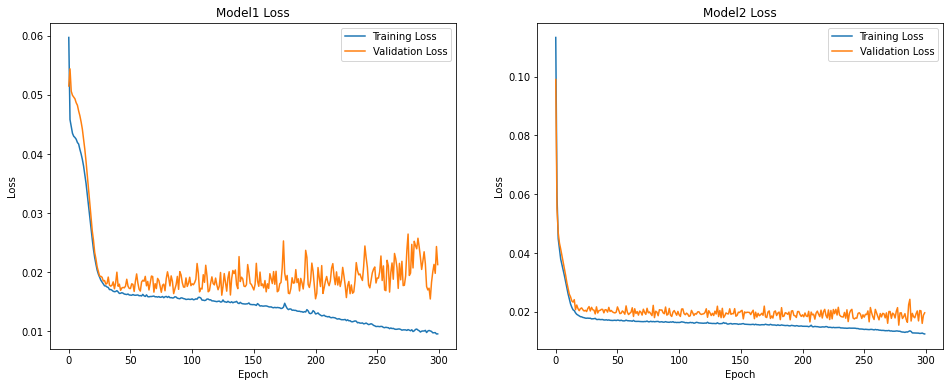

In [195]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(wspace=0.2)
for i, (name, model) in enumerate(models.items()):
    ax[i].set_title(f"{name} Loss")
    ax[i].set_xlabel("Epoch")
    ax[i].set_ylabel("Loss")
    ax[i].plot(range(len(result[name][f"Training Loss"])), result[name][f"Training Loss"], label=f"Training Loss")
    ax[i].plot(range(len(result[name][f"Validation Loss"])),  result[name][f"Validation Loss"], label=f"Validation Loss")
    ax[i].legend()
plt.show()

#### 2.5 From the observation of previous question, please determine a appropriate epoch and retrain two models to avoid overfitting. Also, draw the loss plot of two models and save the last model as ***model1.pth*** and ***model2.pth***.
##### (Note. You should reload the models optimizer, otherwise, you will resume from the previous stop.)

In [198]:
models = {"Model1" : MLP(input_ch=8, first_layers=256, second_layers=64, third_layers=8, activation=nn.Tanh(), output_act = nn.Tanh()), 
            "Model2" : MLP(input_ch=8, first_layers=64, second_layers=16, third_layers=8, activation=nn.Tanh(), output_act = nn.Identity())}
learning_rate = 0.01
criterion = nn.MSELoss()
max_epoch = 50
result = {}

for name, model in models.items():
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    pbar = tqdm(range(max_epoch))
    result[name] = {"Training Loss":[], "Validation Loss":[]}
    for i in pbar:
        training_loss = 0
        val_loss = 0
        for inputs, label in train_dl:
            optimizer.zero_grad()
            pred = model(inputs)
            loss = criterion(pred, label)
            loss.backward()
            optimizer.step()
            training_loss+=loss.detach().numpy()

        for inputs, label in val_dl:
            with torch.no_grad():
                pred = model(inputs)
                loss = criterion(pred, label)
                val_loss+=loss.numpy()
        result[name]["Training Loss"].append(training_loss/len(train_dl))
        result[name]["Validation Loss"].append(val_loss/len(val_dl)) 
        
    torch.save(model.state_dict(), f"{name}.pth")

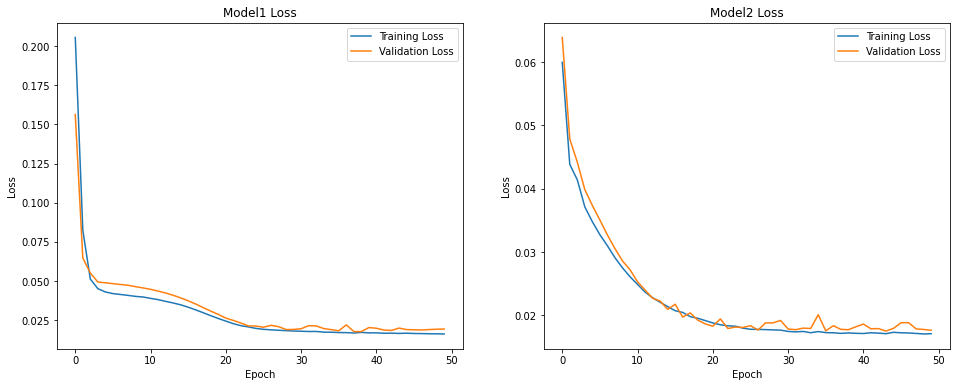

In [199]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(wspace=0.2)
for i, (name, model) in enumerate(models.items()):
    ax[i].set_title(f"{name} Loss")
    ax[i].set_xlabel("Epoch")
    ax[i].set_ylabel("Loss")
    ax[i].plot(range(len(result[name][f"Training Loss"])), result[name][f"Training Loss"], label=f"Training Loss")
    ax[i].plot(range(len(result[name][f"Validation Loss"])),  result[name][f"Validation Loss"], label=f"Validation Loss")
    ax[i].legend()
plt.show()

#### 2.6 Please load the checkpoints saved from previous question and calculate the mean squared error on test dataset for two models respectively. Also, ake a dataframe with target and prediction like below and save it as ***regression.csv***
|Target|Model1|Model2|
|:---:|:---:|:---:|
|24.05|26.35|27.04|
|21.67|32.78|21.95|

In [219]:
from sklearn.metrics import mean_squared_error
models = {"Model1" : MLP(input_ch=8, first_layers=256, second_layers=64, third_layers=8, activation=nn.Tanh(), output_act = nn.Tanh()), 
            "Model2" : MLP(input_ch=8, first_layers=64, second_layers=16, third_layers=8, activation=nn.Tanh(), output_act = nn.Identity())}
test_ds = ConcreteDataset("./data/test.csv")
test_dl = DataLoader(test_ds, batch_size=len(test_ds), shuffle=False)
output = {}
for name, model in models.items():
    for X, y in test_dl:
        model.load_state_dict(torch.load(f"{name}.pth"))
        model.eval()
        with torch.no_grad():
            pred = model(X)
            output["Target"] = test_ds.y_scaler.inverse_transform(y).squeeze()
            output[name] = test_ds.y_scaler.inverse_transform(pred).squeeze()
        print(f"Mean Squared Error ({name}): ", mean_squared_error(output["Target"], output[name]))

Mean Squared Error (Model1):  123.89347662950205
Mean Squared Error (Model2):  115.24500398154892


In [216]:
out = pd.DataFrame(output)

In [220]:
out.to_csv("regression.csv")